In [3]:
!pip install torchinfo

### Import Libraries

In [4]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Configuration

In [6]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [7]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [8]:
data_dir = "/kaggle/input/cotton/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Augmented Dataset/Augmented Dataset"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
#df['label'] = df['label'].str.strip()
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
num_classes = len(label_map)

Class: Leaf Hopper Jassids, Count: 1000
Class: Leaf Redding, Count: 1000
Class: Healthy Leaf, Count: 1000
Class: Herbicide Growth Damage, Count: 1000
Class: Bacterial Blight, Count: 1000
Class: Leaf Variegation, Count: 1000
Class: Curl Virus, Count: 1000


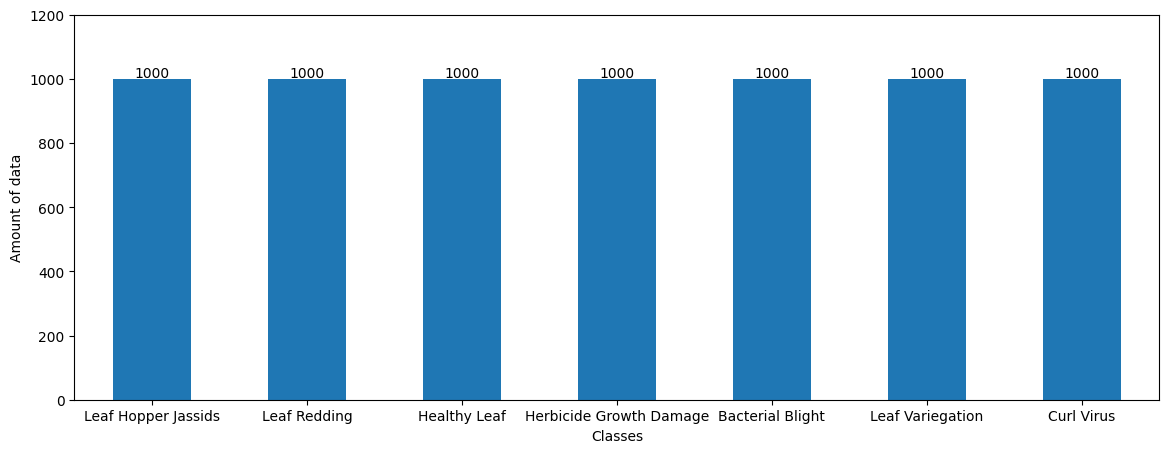

In [10]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 5))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

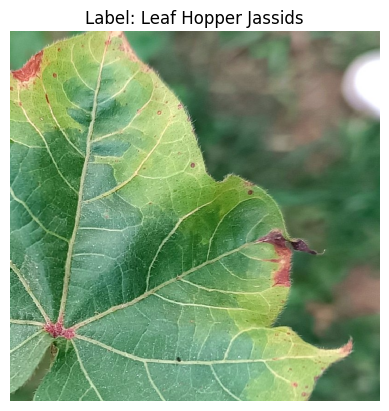

In [13]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [14]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [15]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  4900
Validation Data:  1050
Test Data:  1050
-------------------------------------------
Total amounts of data in the dataset:  7000


In [16]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                      Count
-----------------------  -------
Healthy Leaf                 700
Curl Virus                   700
Bacterial Blight             700
Leaf Redding                 700
Leaf Hopper Jassids          700
Leaf Variegation             700
Herbicide Growth Damage      700

Validation Dataset
Class                      Count
-----------------------  -------
Leaf Variegation             150
Leaf Hopper Jassids          150
Healthy Leaf                 150
Herbicide Growth Damage      150
Curl Virus                   150
Bacterial Blight             150
Leaf Redding                 150

Test Dataset
Class                      Count
-----------------------  -------
Bacterial Blight             150
Leaf Redding                 150
Healthy Leaf                 150
Herbicide Growth Damage      150
Leaf Hopper Jassids          150
Leaf Variegation             150
Curl Virus                   150


### Device Variable

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [19]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [20]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [21]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [23]:
num_classes = len(label_map)  
learning_rate = 0.0001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(model.fc.in_features, num_classes) 
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 7]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

### Training

In [24]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=10, early_stop_patience=10, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/10: 100%|██████████| 154/154 [00:39<00:00,  3.89it/s, acc=0.911, loss=0.288]

Training Loss: 0.288 Acc: 0.911


Validation Loss: 0.061 Acc: 0.981
Best model saved at epoch 1 with validation accuracy: 0.981


Epoch 2/10: 100%|██████████| 154/154 [00:34<00:00,  4.48it/s, acc=0.981, loss=0.0671]

Training Loss: 0.067 Acc: 0.981


Validation Loss: 0.084 Acc: 0.985
Best model saved at epoch 2 with validation accuracy: 0.985


Epoch 3/10: 100%|██████████| 154/154 [00:34<00:00,  4.49it/s, acc=0.987, loss=0.0379]

Training Loss: 0.038 Acc: 0.987


Validation Loss: 0.068 Acc: 0.985


Epoch 4/10: 100%|██████████| 154/154 [00:34<00:00,  4.50it/s, acc=0.995, loss=0.0167]

Training Loss: 0.017 Acc: 0.995


Validation Loss: 0.111 Acc: 0.970


Epoch 5/10: 100%|██████████| 154/154 [00:34<00:00,  4.50it/s, acc=0.99, loss=0.034]  

Training Loss: 0.034 Acc: 0.990


Validation Loss: 0.095 Acc: 0.981


Epoch 6/10: 100%|██████████| 154/154 [00:34<00:00,  4.49it/s, acc=0.985, loss=0.0523]

Training Loss: 0.052 Acc: 0.985


Validation Loss: 0.075 Acc: 0.985


Epoch 7/10: 100%|██████████| 154/154 [00:34<00:00,  4.52it/s, acc=0.989, loss=0.0421]

Training Loss: 0.042 Acc: 0.989


Validation Loss: 0.074 Acc: 0.984


Epoch 8/10: 100%|██████████| 154/154 [00:34<00:00,  4.50it/s, acc=0.998, loss=0.0109] 

Training Loss: 0.011 Acc: 0.998


Validation Loss: 0.085 Acc: 0.983


Epoch 9/10: 100%|██████████| 154/154 [00:34<00:00,  4.52it/s, acc=0.995, loss=0.019]  

Training Loss: 0.019 Acc: 0.995


Validation Loss: 0.090 Acc: 0.979


Epoch 10/10: 100%|██████████| 154/154 [00:34<00:00,  4.49it/s, acc=0.988, loss=0.0408]

Training Loss: 0.041 Acc: 0.988


Validation Loss: 0.075 Acc: 0.973
Training Time: 413.99 seconds ---> 6.90 minutes


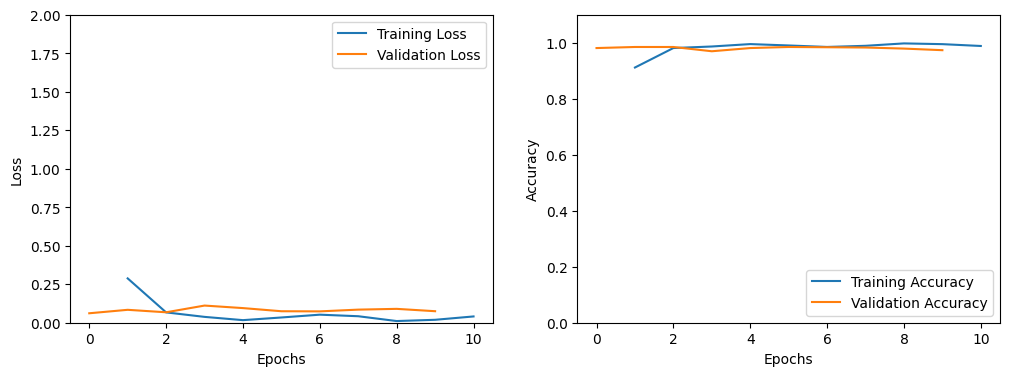

In [26]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [27]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [29]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 2) - Validation Loss: 0.084, Validation Accuracy: 0.985


In [30]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.974
Test Time: 8.21 seconds ---> 0.14 minutes


In [32]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(num_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, num_classes)
for i in range(num_classes):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       150
           1       0.96      0.98      0.97       150
           2       0.99      0.97      0.98       150
           3       0.99      0.98      0.98       150
           4       0.96      0.99      0.97       150
           5       0.96      0.97      0.96       150
           6       1.00      0.98      0.99       150

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050

Class 0 Accuracy: 0.953
Class 1 Accuracy: 0.980
Class 2 Accuracy: 0.973
Class 3 Accuracy: 0.980
Class 4 Accuracy: 0.987
Class 5 Accuracy: 0.967
Class 6 Accuracy: 0.980
